In [18]:
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict
import data_utils
from tsne import getScaledTsneEmbedding
from mdp import MDP
from env import Env
from q_learning import QLearningAlgo
from policy import EpsilonGreedyPolicy, GreedyPolicy, AlwaysDoPolicy, RandomPolicy

In [2]:
data = data_utils.Data()

100%|██████████| 53/53 [00:25<00:00,  1.59it/s]


In [108]:
data.mode = 'test'
data.size()

8135

In [3]:
mdp = MDP(data = data)

In [60]:
def reward_func_simple_decay(stats, verbose=False):
    """
    Decay with k, no entropy
    :param stats:
    :param verbose:
    :return:
    """
    mean_conf_gender, mean_conf_age, mean_entropy_change, dev_conf_gender, dev_conf_age, dev_entropy_change = stats
    if verbose:
        print("Maximum confidences in GENDER classification has mean %.4f and standard deviation %.4f" % (
            mean_conf_gender, dev_conf_gender))
        print("Maximum confidences in AGE classification has mean %.4f and standard deviation %.4f" % (
            mean_conf_age, dev_conf_age))
        print("Entropy change has mean %.4f and standard deviation %.4f" % (
            mean_entropy_change, dev_entropy_change))

    # Params: action -> 0 or 1, states -> State objects
    def func(prev_state, action):
        c_g = prev_state.confidence('gender')
        c_a = prev_state.confidence('age')

        # TODO experiment with different cost weights
        reward_conf = .5 * (((c_g - mean_conf_gender) / dev_conf_gender) + 1) + \
                      .5 * (((c_a - mean_conf_age) / dev_conf_age) + 1)

        cost = 0.8 + (prev_state.k_max - prev_state.k)
        reward = reward_conf - cost
        if action == 1:
            reward = reward_conf - cost
        elif action == 0:
            # Punish with lost opportunity - or reward with it
            reward = 0 # reward_conf - 1
        return reward, 0, reward_conf, cost

    return func

def reward_func_linear(stats, init_cost = 1., verbose=False):
    mean_conf_gender, mean_conf_age, mean_entropy_change, dev_conf_gender, dev_conf_age, dev_entropy_change = stats
    if verbose:
        print("Maximum confidences in GENDER classification has mean %.4f and standard deviation %.4f" % (
            mean_conf_gender, dev_conf_gender))
        print("Maximum confidences in AGE classification has mean %.4f and standard deviation %.4f" % (
            mean_conf_age, dev_conf_age))
        print("Entropy change has mean %.4f and standard deviation %.4f" % (
            mean_entropy_change, dev_entropy_change))

    # Params: action -> 0 or 1, states -> State objects
    def func(prev_state, action):
        c_g = prev_state.confidence('gender')
        c_a = prev_state.confidence('age')

        cost = init_cost
        reward_conf = .5 * (((c_g - mean_conf_gender) / dev_conf_gender) + 1) + \
                      .5 * (((c_a - mean_conf_age) / dev_conf_age) + 1)

        alpha = .5
        # Compute entropy change.
        # Negative if current state's entropy is higher than previous state's.
        # Reward decreasing entropy change
        ec = prev_state.entropy_change

        reward_entropy = .5 * (((ec - mean_entropy_change) / dev_entropy_change) + 1)

        # Clip max min values
        if reward_entropy < 0:
            reward_entropy = 0
        elif reward_entropy > 2:
            reward_entropy = 2

        reward = action * ((alpha * reward_conf + (1 - alpha) * reward_entropy) - cost)
        return reward, reward_entropy, reward_conf, cost

    return func


In [102]:
reward_func = reward_func_simple_decay(data.statistics, verbose=False)

In [103]:
# FIND REWARD COST
from tqdm import tqdm

r, r_ec, r_c, eps_ids, best_reward_idx, best_reward, res, cost = [], [], [], [], [], [], [], []
mdp.set_mode('test')
mdp.reset()
# test_policy = EpsilonGreedyPolicy(action_space = mdp.action_space)
# policy = RandomPolicy(action_space = mdp.action_space)
policy = AlwaysDoPolicy(action_space = mdp.action_space)
c = 0
for i in tqdm(range(mdp.data.size())):
    action = policy.sample()
    prev_state, action, state = mdp.doAction(action)
    reward, reward_entropy, reward_conf, ct= reward_func(prev_state, action)
    r.append(reward); r_ec.append(reward_entropy); r_c.append(reward_conf)
    eps_ids.append(c); res.append(state.resolution); cost.append(ct)
    c += 1
    if mdp.is_terminal:
        best_reward_idx.append(np.argmax(r_c[-c:])); best_reward.append(max(r_c[-c:]))
        c = 0
        mdp.reset()


100%|██████████| 8135/8135 [00:00<00:00, 12807.11it/s]


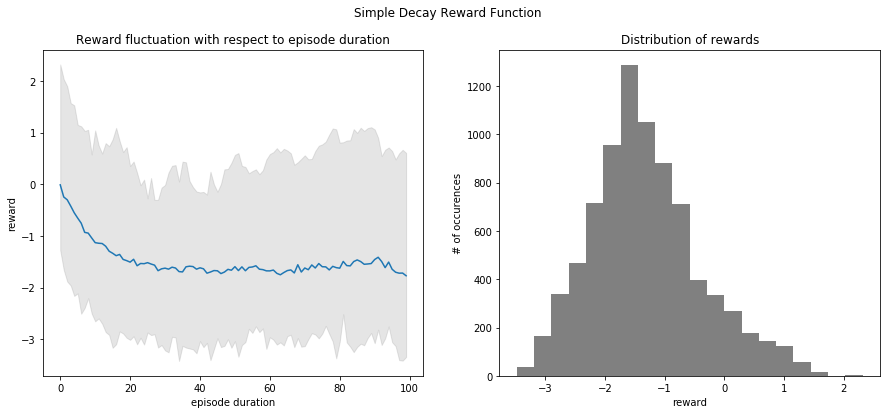

In [105]:
my_dict = OrderedDict([])
for idx, reward in zip(eps_ids, r):
    if idx in my_dict:
        my_dict[idx].append(reward)
    else:
        my_dict[idx] = [reward]

lower = []
upper = []
average = []
for idx, rewards in my_dict.items():
    lower.append(min(rewards))
    upper.append(max(rewards))
    average.append(np.mean(rewards))

average = average[:100]
lower = lower[:100]
upper = upper[:100]
    
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()

# Plot reward vs episode idx
axes[0].set_xlabel("episode duration")
axes[0].set_ylabel("reward")
# axes.scatter(eps_ids, r, s=0.6)
axes[0].plot(average)
axes[0].fill_between(list(range(len(average))), lower, upper, color='grey', alpha=.2)
axes[0].set_title("Reward fluctuation with respect to episode duration")

axes[1].set_xlabel("reward")
axes[1].set_ylabel("# of occurences")
# axes[1].set_ylim()
axes[1].hist(r, bins = 20, color = 'grey')
axes[1].set_title("Distribution of rewards")
fig.suptitle("Simple Decay Reward Function")
plt.show()

Maximum available reward 1318.3878167266093


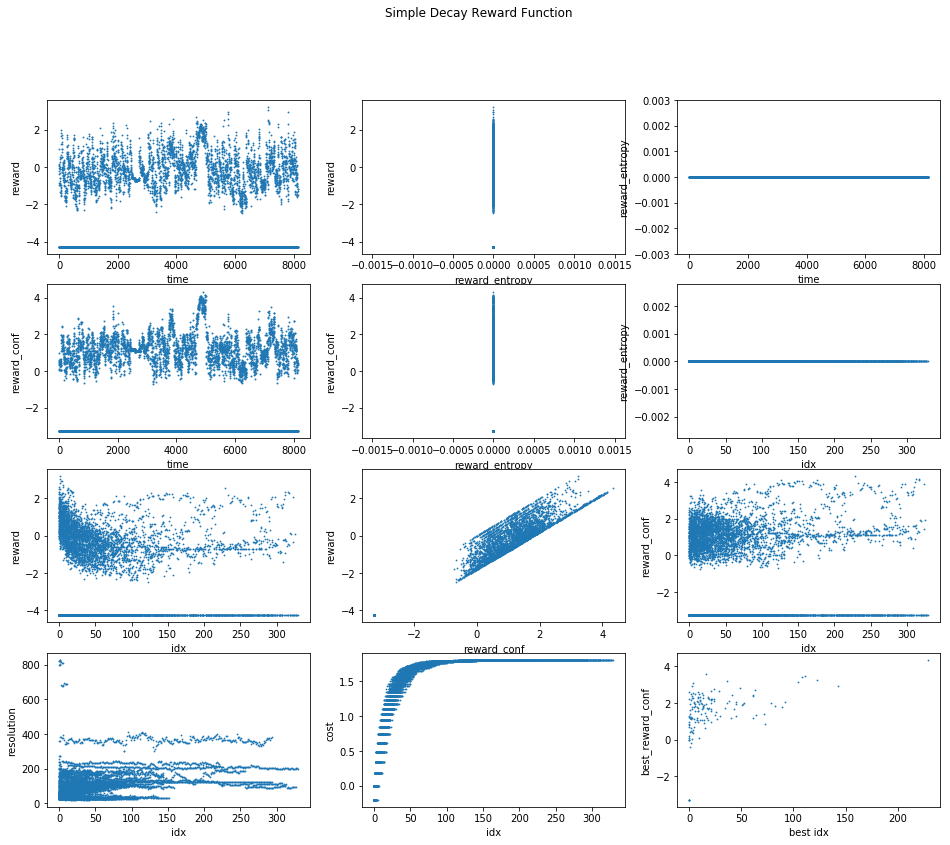

In [30]:
fig, axes = plt.subplots(4, 3, figsize=(16, 13))
axes = axes.flatten()

# Plot reward vs time
idx = 0
axes[idx].set_xlabel("time")
axes[idx].set_ylabel("reward")
axes[idx].scatter(list(range(len(r))), r, s=0.7)

# Plot reward vs reward_entropy
idx = 1
axes[idx].set_xlabel("reward_entropy")
axes[idx].set_ylabel("reward")
axes[idx].scatter(r_ec, r, s=0.6)

# Plot reward_entropy vs time
idx = 2
axes[idx].set_xlabel("time")
axes[idx].set_ylabel("reward_entropy")
axes[idx].scatter(list(range(len(r_ec))), r_ec, s=0.7)

# Plot reward_conf vs time
idx = 3
axes[idx].set_xlabel("time")
axes[idx].set_ylabel("reward_conf")
axes[idx].scatter(list(range(len(r_c))), r_c, s=0.9)

# Plot reward_entropy vs reward_conf
idx = 4
axes[idx].set_xlabel("reward_entropy")
axes[idx].set_ylabel("reward_conf")
axes[idx].scatter(r_ec, r_c, s=0.6)

# Plot reward_entropy vs episode idx
idx = 5
axes[idx].set_xlabel("idx")
axes[idx].set_ylabel("reward_entropy")
axes[idx].scatter(eps_ids, r_ec, s=0.6)

# Plot reward_entropy vs episode idx
idx = 6
axes[idx].set_xlabel("idx")
axes[idx].set_ylabel("reward")
axes[idx].scatter(eps_ids, r, s=0.6)

# Plot reward vs reward_conf
idx = 7
axes[idx].set_xlabel("reward_conf")
axes[idx].set_ylabel("reward")
axes[idx].scatter(r_c, r, s=0.6)

# Plot reward_conf vs episode idx
idx = 8
axes[idx].set_xlabel("idx")
axes[idx].set_ylabel("reward_conf")
axes[idx].scatter(eps_ids, r_c, s=0.6)

# Plot resolution vs episode idx
idx = 9
axes[idx].set_xlabel("idx")
axes[idx].set_ylabel("resolution")
axes[idx].scatter(eps_ids, res, s=0.6)

# PLot cost vs episode idx
idx = 10
axes[idx].set_xlabel("idx")
axes[idx].set_ylabel("cost")
axes[idx].scatter(eps_ids, cost, s=0.6)

# Plot best reward idx
idx = 11
axes[idx].set_xlabel("best idx")
axes[idx].set_ylabel("best_reward_conf")
axes[idx].scatter(best_reward_idx, best_reward, s=0.6)


fig.suptitle("Simple Decay Reward Function")
r = np.array(r)
print("Maximum available reward", np.sum(r[r > 0]))
plt.show()